# Hubway Challenge

The 2017 Hubway Data Challenge presented by Microsoft was built to offer a challenge that asked participants to go deeper than your typical bike availability app, with experienced & interesting judges, fun & useful & valuable prizes, and the right partner, so that we could formally recognize those volunteering their time to improve Hubway.

The ideia is to build a streamlit application, that the user can explore the data generating insights to improve the service 

## 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

## 1.0 Load Data

In [2]:
hubway_data = pd.read_csv('data/hubway_trips.csv', low_memory=False)

hubway_data.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [7]:
hubway_data.shape

(1579025, 13)

## 1.1 A little data manipulation

In [8]:
check_out_year = hubway_data['start_date'].apply(lambda s: int(s[-13:-9]))
year_to_age = (check_out_year - hubway_data['birth_date'])

# Who

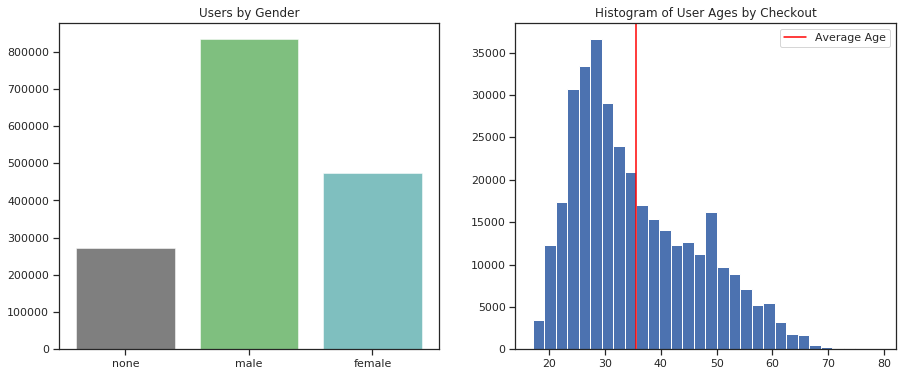

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#And now for our first plot: a barplot of gender 
gender_counts = np.unique(hubway_data['gender'].replace(np.nan, 'NaN', regex=True).values, return_counts=True)
ax[0].bar(range(3), gender_counts[1], align='center', color=['black', 'green', 'teal'], alpha=0.5)
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['none', 'male', 'female', ' '])
ax[0].set_title('Users by Gender')

#And a histogram of ages

ax[1].hist(year_to_age.dropna(),bins=30)
ax[1].set_title('Histogram of User Ages by Checkout')
ax[1].axvline(x=np.mean(year_to_age.dropna()), color='red', label='Average Age')
ax[1].legend()

plt.show()

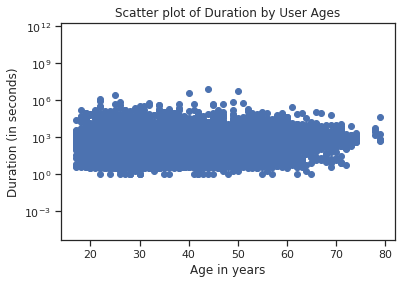

In [10]:
#And now for a second plot: scatter plot of age with duration
plt.yscale('log')
plt.scatter(year_to_age,hubway_data.duration+1)
plt.title('Scatter plot of Duration by User Ages')
plt.xlabel('Age in years')
plt.ylabel('Duration (in seconds)')
plt.show()

# Where

In [12]:
station_data = pd.read_csv('data/hubway_stations.csv', low_memory=False)[['id', 'lat', 'lng']]
station_data.head()

,id,lat,lng
0,3,42.340021,-71.100812
1,4,42.345392,-71.069616
2,5,42.341814,-71.090179
3,6,42.361285,-71.065140
4,7,42.353412,-71.044624


In [13]:
hubway_data_with_gps = hubway_data.join(station_data.set_index('id'), on='strt_statn')
hubway_data_with_gps.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,lat,lng
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,42.359677,-71.059364
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,42.359677,-71.059364
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,42.359677,-71.059364
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,42.359677,-71.059364
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,42.359677,-71.059364


# When

In [14]:
#check_out_times = pd.to_datetime(hubway_data['start_date'])
check_out_hours = hubway_data['start_date'].apply(lambda s: int(s[-8:-6]))

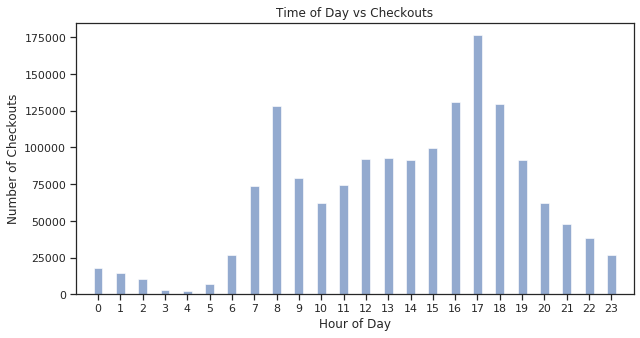

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

check_out_counts = np.unique(check_out_hours, return_counts=True)
ax.bar(check_out_counts[0], check_out_counts[1], align='center', width=0.4, alpha=0.6)
ax.set_xlim([-1, 24])
ax.set_xticks(range(24))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Checkouts')
ax.set_title('Time of Day vs Checkouts')

plt.show()

# How

In [16]:
def haversine(pt, lat2=42.355589, lon2=-71.060175):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = pt[0]
    lat1 = pt[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles
    return c * r

In [17]:
station_counts = np.unique(hubway_data_with_gps['strt_statn'].dropna(), return_counts=True)
counts_df = pd.DataFrame({'id':station_counts[0], 'checkouts':station_counts[1]})
counts_df = counts_df.join(station_data.set_index('id'), on='id')

#add distance
counts_df.loc[:, 'dist_to_center'] = list(map(haversine, counts_df[['lng', 'lat']].values))
counts_df.head()

,id,checkouts,lat,lng,dist_to_center
0,3.0,9734,42.340021,-71.100812,2.335706
1,4.0,18058,42.345392,-71.069616,0.853095
2,5.0,10630,42.341814,-71.090179,1.802423
3,6.0,23322,42.361285,-71.065140,0.467803
4,7.0,9163,42.353412,-71.044624,0.807582


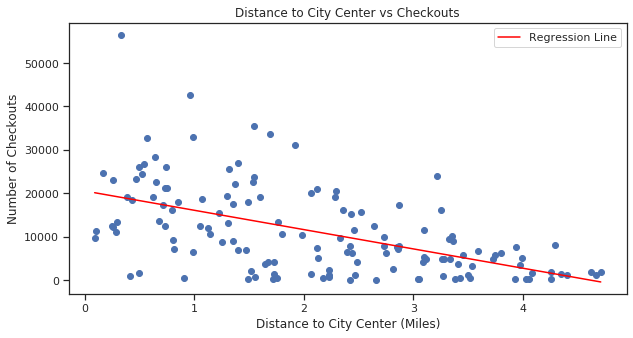

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(counts_df['dist_to_center'].values, counts_df['checkouts'].values)

reg_line = LinearRegression()
reg_line.fit(counts_df['dist_to_center'].values.reshape((len(counts_df['dist_to_center']), 1)), counts_df['checkouts'].values)

distances = np.linspace(counts_df['dist_to_center'].min(), counts_df['dist_to_center'].max(), 50)

ax.plot(distances, reg_line.predict(distances.reshape((len(distances), 1))), color='red', label='Regression Line')

ax.set_xlabel('Distance to City Center (Miles)')
ax.set_ylabel('Number of Checkouts')
ax.set_title('Distance to City Center vs Checkouts')
ax.legend()

plt.savefig('How.png', dpi=300)

In [19]:
#let's look at some subgroups
print(np.unique(hubway_data.subsc_type,return_counts=True))

(array(['Casual', 'Registered'], dtype=object), array([ 472611, 1106414]))


733.3289835450383
2293.4422135752234


/home/jvbf/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


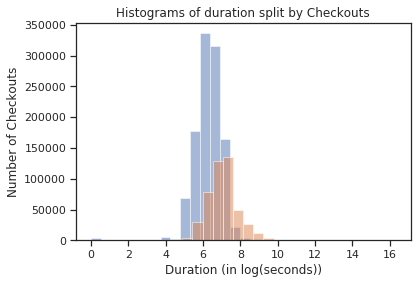

In [20]:
#And now for a plot of histograms across registration type
duration_registered = (hubway_data.duration[hubway_data.subsc_type == 'Registered'])
duration_casual = (hubway_data.duration[hubway_data.subsc_type == 'Casual'])

print(np.mean(duration_registered))
print(np.mean(duration_casual))

logduration_registered = np.log(duration_registered+1)
logduration_casual = np.log(duration_casual+1)

plt.hist(logduration_registered.dropna(), alpha=.5, bins=30)
plt.hist(logduration_casual.dropna(), alpha=.5, bins=30)

#plt.hist(duration_registered.dropna()+1, alpha=.5)
#plt.hist(duration_casual.dropna()+1, alpha=.5)
plt.title('Histograms of duration split by Checkouts')
plt.xlabel('Duration (in log(seconds))')
plt.ylabel('Number of Checkouts')
#plt.xscale('log')

plt.show()